# Binary Classification
In this file, I'll create and evaluate a binary [classification model](https://developers.google.com/machine-learning/glossary/#classification_model).

That is, I'll create a model that answers a binary question. In this exercise, the binary question will be,

"Are houses in this neighborhood above a certain price?"

## Learning Objectives:

  * Convert a regression question into a classification question.
  * Modify the classification threshold and determine how that modification influences the model.
  * Experiment with different classification metrics to determine your model's effectiveness.

## The Dataset:

I will use the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

In [1]:
#@title Load the imports

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")

Ran the import statements.


## Load the dataset from the internet

Load the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set
* `test_df`, which contains the test set

In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

## Normalize values
When creating a model with multiple features, the values of each feature should cover roughly the same range. For example, if one feature's range spans 500 to 100'000 and another featureìs range spans 2 to 12, then the model would be difficult or impossible to train. Therefore, I will
[normalize](https://developers.google.com/machine-learning/glossary/#normalization) features in a multi-feature model.

The following code cell normalizes datasets by converting each raw value (including the label) to its Z-score. A **Z-score** is the number of standard deviations from the mean for a particular raw value. For example, consider a feature having the following characteristics:

  * The mean is 60.
  * The standard deviation is 10.

The raw value 75 would have a Z-score of +1.5:

```
  Z-score = (75 - 60) / 10 = +1.5
```

The raw value 38 would have a Z-score of -2.2:

```
  Z-score = (38 - 60) / 10 = -2.2
```

In [3]:
# Calculate the Z-scores of each column in the training set and
# write those Z-scores into a new pandas DataFrame named train_df_norm.
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Examine some of the values of the normalized training set. Notice that most
# Z-scores fall between -2 and +2.
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
3360,0.8,-0.8,-0.9,1.6,0.8,1.2,0.9,2.0,0.9
11715,-0.9,1.1,1.9,-1.2,-1.3,-1.2,-1.3,-0.8,-1.2
7322,0.6,-0.8,-0.9,0.5,1.1,1.0,1.2,-0.3,-0.0
2174,1.1,-1.1,0.0,-0.6,-0.5,-0.0,-0.5,-1.0,-0.9
7381,0.6,-0.7,1.4,-0.5,-0.3,-0.8,-0.3,0.1,1.2


In [4]:
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
16272,-122.5,37.8,52.0,2245.0,425.0,1091.0,409.0,3.6,331200.0
7021,-118.3,33.8,35.0,3462.0,814.0,1902.0,700.0,3.4,279900.0
1136,-117.1,32.8,28.0,2160.0,608.0,1339.0,571.0,1.9,128100.0
8850,-118.7,34.3,11.0,5451.0,736.0,2526.0,752.0,7.4,343900.0
14882,-122.2,37.5,13.0,2888.0,546.0,1182.0,504.0,6.0,409300.0


In [4]:
test_df_norm = (test_df - train_df_mean) / train_df_std

# Note:
# I'm trasforming the test data with the values calculated from the training
# as I should always transform my datasets with exactly the same values.

## Create a binary label
In classification problems the label must be either 0 or 1 for every example. Unfortunately the natural label in the California Housing Dataset, `median_house_value`, contains floating-point values like 80,100 or 85,700 rather than 0s and 1s, while the normalizd version of `median_house_values` contains floating-point values primarly between -3 and +3.

The task is to create a new column named `median_house_value_is_high` in both the training and the test set. If the `median_house_value` is higher than a certain arbitrary value (defined by `threshold`), then set `median_house_value_is_high` to 1. Otherwise set it to 0.

**Plus:** To convert `True` and `False` to `1` and `0`, I'll use the pandas DataFrame function `astype(float)`.

In [5]:
threshold = 265000 #75th percentile for median house values.
train_df_norm["median_house_value_is_high"] = (train_df["median_house_value"] > threshold).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df["median_house_value"] > threshold).astype(float)

train_df_norm["median_house_value_is_high"].head(8000)

3360    1.0
11715   0.0
7322    0.0
2174    0.0
7381    1.0
         ..
5750    0.0
7226    1.0
13331   0.0
15614   0.0
6133    0.0
Name: median_house_value_is_high, Length: 8000, dtype: float64

## Represent features as input layers
Here I specify the features, `median_income` and `total_rooms`, that I'll ultimately train the model on. These Input objects are instantiated as Keras tensors.

In [6]:
inputs = {
    # Features used to train the model on.
    'median_income': tf.keras.Input(shape=(1,)),
    'total_rooms': tf.keras.Input(shape=(1,))
}

## Functions definition to create and train a model

In [14]:
#@title Define the functions to create and train a model

def create_model(my_inputs, my_learning_rate, METRICS):
    """
    Create and compile a simple classification model.
    """
    # Use a Concatenate layer to concatenate the input layers into a single
    # tensor as input for the Dense layer.
    # Ex: [input_1[0][0], input_2[0][0]]
    concatenated_inputs = tf.keras.layers.Concatenate()(my_inputs.values())
    dense = layers.Dense(units=1, name="dense_layer", activation=tf.sigmoid)
    dense_output = dense(concatenated_inputs)
    
    my_outputs = {
        'dense': dense_output,
    }
    model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)
    model.compile(
        optimizer=tf.keras.optimizers.experimental.RMSprop(
            learning_rate=my_learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=METRICS)
    return model

def train_model(model, dataset, epochs, label_name, baatch_size=None, shuffle=True):
    """
    Feed a dataset into the model in order to train it.
    """
    
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features,
                       y=label,
                       batch_size=batch_size,
                       epochs=epochs,
                       shuffle=shuffle)
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist

print("Defined create_model and train_model functions.")

Defined create_model and train_model functions.


## Define a plotting functions
Through matplotlib.

In [20]:
def plot_curve(epochs, hist, list_of_metrics):
    """
    Plot a curve of one or more classification metrics vs. epoch.
    """
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    
    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)
    
    plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


## Model definition

In [11]:
# Hyperparameters:
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

# Establish the metrics the model will measure.
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy',
                                   threshold=classification_threshold)
]

# Establish the model's topography.

my_model = create_model(inputs, learning_rate, METRICS)

# tf.keras.utils.plot_model(my_model, "my_classification_model.png")

In [15]:
epochs, hist = train_model(my_model, train_df_norm, epochs,
                           label_name, batch_size)

Epoch 1/20


C:\Users\andre\Desktop\AI learning\ai\Lib\site-packages\keras\src\engine\functional.py:639: UserWarning: Input dict contained keys ['longitude', 'latitude', 'housing_median_age', 'total_bedrooms', 'population', 'households', 'median_house_value'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


170/170 [==============================] - 2s 4ms/step - loss: 0.6206 - accuracy: 0.2911
Epoch 2/20
170/170 [==============================] - 1s 4ms/step - loss: 0.5513 - accuracy: 0.4574
Epoch 3/20
170/170 [==============================] - 1s 4ms/step - loss: 0.5010 - accuracy: 0.6316
Epoch 4/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4654 - accuracy: 0.7105
Epoch 5/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4401 - accuracy: 0.7503
Epoch 6/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4224 - accuracy: 0.7748
Epoch 7/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4108 - accuracy: 0.7901
Epoch 8/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4042 - accuracy: 0.7993
Epoch 9/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4006 - accuracy: 0.8041
Epoch 10/20
170/170 [==============================] - 1s 4ms/step - loss: 0.3986 - accuracy: 0.8072
Epoch 11/2

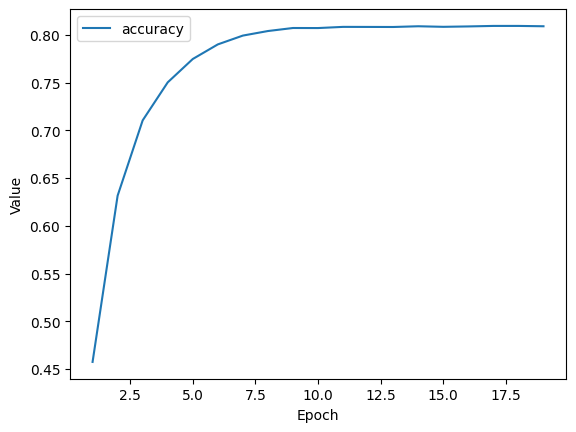

In [24]:
# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

In [25]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

30/30 [==============================] - 1s 4ms/step - loss: 0.4071 - accuracy: 0.8050


[0.40709438920021057, 0.8050000071525574]

In [26]:
# Result interpretation:
# Accuracy = Correct Predictions / Total Predictions
# perfect model has 100% of accuracy
# always false has 75% of accuracy

# 80% seems good but feels there could be also improvement

Epoch 1/20
170/170 [==============================] - 2s 4ms/step - loss: 0.9434 - accuracy: 0.3434 - precision: 0.0842 - recall: 0.1648
Epoch 2/20
170/170 [==============================] - 1s 4ms/step - loss: 0.8428 - accuracy: 0.4608 - precision: 0.0717 - recall: 0.0970
Epoch 3/20
170/170 [==============================] - 1s 4ms/step - loss: 0.7564 - accuracy: 0.6422 - precision: 0.0858 - recall: 0.0447
Epoch 4/20
170/170 [==============================] - 1s 4ms/step - loss: 0.6828 - accuracy: 0.7235 - precision: 0.1542 - recall: 0.0238
Epoch 5/20
170/170 [==============================] - 1s 4ms/step - loss: 0.6216 - accuracy: 0.7389 - precision: 0.2019 - recall: 0.0153
Epoch 6/20
170/170 [==============================] - 1s 4ms/step - loss: 0.5711 - accuracy: 0.7454 - precision: 0.2990 - recall: 0.0144
Epoch 7/20
170/170 [==============================] - 1s 4ms/step - loss: 0.5302 - accuracy: 0.7495 - precision: 0.4674 - recall: 0.0202
Epoch 8/20
170/170 [=====================

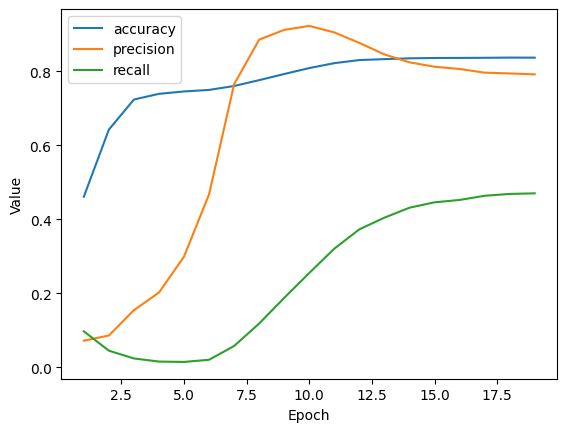

In [33]:
# Let us add precision and recall
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.52 #modified using new metrics
label_name = "median_house_value_is_high"
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy',
                                   threshold=classification_threshold),
    tf.keras.metrics.Precision(name='precision',
                              thresholds=classification_threshold),
    tf.keras.metrics.Recall(name='recall',
                           thresholds=classification_threshold)
]

my_model = create_model(inputs, learning_rate, METRICS)

epochs, hist = train_model(my_model, train_df_norm, epochs,
                           label_name, batch_size)

list_of_metrics_to_plot = ['accuracy', 'precision', 'recall']
plot_curve(epochs, hist, list_of_metrics_to_plot)

## Model Performance Summary

Epoch 1/20
170/170 [==============================] - 2s 4ms/step - loss: 0.9067 - auc: 0.2207
Epoch 2/20
170/170 [==============================] - 1s 4ms/step - loss: 0.8117 - auc: 0.2337
Epoch 3/20
170/170 [==============================] - 1s 4ms/step - loss: 0.7287 - auc: 0.2557
Epoch 4/20
170/170 [==============================] - 1s 4ms/step - loss: 0.6580 - auc: 0.2990
Epoch 5/20
170/170 [==============================] - 1s 4ms/step - loss: 0.5989 - auc: 0.4218
Epoch 6/20
170/170 [==============================] - 1s 4ms/step - loss: 0.5507 - auc: 0.6829
Epoch 7/20
170/170 [==============================] - 1s 4ms/step - loss: 0.5134 - auc: 0.7887
Epoch 8/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4836 - auc: 0.8171
Epoch 9/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4600 - auc: 0.8268
Epoch 10/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4418 - auc: 0.8313
Epoch 11/20
170/170 [============================

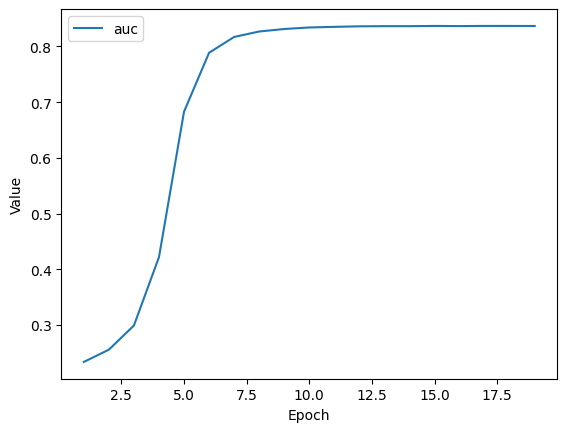

In [34]:
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"

# AUC is a reasonable "summary" metric for
# classification models.
# Here is the updated definition of METRICS to
# measure AUC:
METRICS = [
      tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
my_model = create_model(inputs, learning_rate, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs,
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['auc']
plot_curve(epochs, hist, list_of_metrics_to_plot)